Dans le texte qui suit nous allons continuer à interpréter les données provenant de la compétition "Ghoul, Ghost and Goblin" organisée par le site internet kaggle.com durant le mois d'octobre 2016. Dans la section précédente, j'ai décrit les données et expliqué la démarche que j'ai suivie lors de l'exploration des données à classer. Maintenant, nous sommes à l'étape de la modélisation des données. Commençons par enregistrer les données de la compétition dans les data table monstres et monstres_test, contenant les données servant à entraîner nos algorithmes et à valider le modèle, respectivement. (Note: je vais passé rapidement sur ces étapes puisque je j'ai déjà expliqué ces étapes dans la section précédente accessible à l'adresse https://github.com/GTouzin/Portfolio/blob/master/R/Kaggle_GGG_exploration.ipynb) 

In [1]:
# Charger les packages à utiliser
library(data.table)
library(ggplot2)
library(ggthemes)
library(corrplot)


#Lire les données 
monstres <- fread("./Kaggle/train/train.csv",stringsAsFactors = T)
monstres_test <- fread("./Kaggle/test/test.csv",stringsAsFactors = T)
head(monstres)

Warning message:
"package 'ggplot2' was built under R version 3.3.2"Warning message:
"package 'corrplot' was built under R version 3.3.2"

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
1,0,0.354512184582154,0.35083902671065,0.465760891829121,0.78114166586219,clear,Ghoul
2,1,0.575559905025466,0.425868432210585,0.531401378709141,0.439898877037289,green,Goblin
3,2,0.467875498742323,0.354330420391775,0.811616089668924,0.791224973337769,black,Ghoul
4,4,0.776652460655474,0.508722549943229,0.636765579959788,0.884463692097697,black,Ghoul
5,5,0.56611660205779,0.875861795506256,0.41859367087488,0.636437818727937,green,Ghost
6,7,0.405679744891883,0.253277496666039,0.441419671072687,0.28032381992139,green,Goblin


Ensuite, j'ai créé deux échantillons aléatoires: train contenant les données que j'ai utilisé pour entraîner les différents algorithmes et cross_val contenant le reste des données qui serviront lors de la validation croisée.

In [32]:
set.seed(97)
train.indice <- sample(1:nrow(monstres), round(nrow(monstres)*0.7))
train <- monstres[train.indice , ]
cross_val <- monstres[-train.indice , ]

Finalement, j'ajoute aux data table des colonnes contenant les nouvelles variables que j'ai crues bon créer durant l'exploration des données.

In [33]:
train$soul_square=train$has_soul*train$has_soul
train$hair_square=train$hair_length*train$hair_length
train$bone_square=train$bone_length*train$bone_length

train$hair_time_soul=train$hair_length*train$has_soul
train$hair_time_bone=train$hair_length*train$bone_length
train$bone_time_soul=train$bone_length*train$has_soul

train$color<-as.factor(train$color)
train$type<-as.factor(train$type)

In [34]:
cross_val$hair_square=cross_val$hair_length*cross_val$hair_length
cross_val$soul_square=cross_val$has_soul*cross_val$has_soul
cross_val$bone_square=cross_val$bone_length*cross_val$bone_length

cross_val$hair_time_soul=cross_val$hair_length*cross_val$has_soul
cross_val$hair_time_bone=cross_val$hair_length*cross_val$bone_length
cross_val$bone_time_soul=cross_val$bone_length*cross_val$has_soul    

cross_val$color <- factor(cross_val$color)
cross_val$type <- factor(cross_val$type)

# Modèle de base : Kmeans 


Avant de créer des nouvelles variables, nous allons créer un modèle contenant toutes les variables dans le tableau et estimer l'efficacité du modèle. Cela va nous permettre d'avoir une valeur de référence pour vérifier si on fait des bons choix dans l'élaboration du modèle.

J'ai choisi d'utiliser l'algorithme "Kmeans" pour créer le premier modèle, car ce dernier a pour avantage d'être rapide, simple et n'utilise pas beaucoup de mémoire. Donc, cet algorithme est idéal pour tester des hypothèses. De plus, cette méthode fait partie d'une classe d'algorithmes d'ont l'efficacité dépend grandement de la séparation des données provenant des trois catégories. Donc si l'algorithme "K-means" est peu efficace, nous pourrons conclure que ces autres algorithmes seront à éviter pour modéliser ces données qui ne sont pas linéairement séparables.    

Commençons par changer les valeurs de la variable catégorique "color" en valeur numérique normalisées.

In [35]:
library(plyr)
train$color<-revalue(train$color, c("black"=0, "blood"=1/5, "blue"=2*1/5, "clear"=3*1/5, "green"=4*1/5, "white"=1))
levels(train$color)

[1] "0"   "0.2" "0.4" "0.6" "0.8" "1"

In [36]:
set.seed(97)
vars <- names(train) %in% c("bone_length", "rotting_flesh", "hair_length","has_soul","color")
model.kmeans.base <- kmeans(subset(train, select=vars), 3, nstart = 50)

Examinons la justesse du modèle en créant un tableau de contingence où les lignes contiennent les effectifs des grappes de points générés par l'algorithme et où les colonnes contiennent les véritables effectifs de chacune des trois catégories.

In [37]:
table<-table(model.kmeans.base$cluster, train$type)
table

   
    Ghost Ghoul Goblin
  1    20    42     37
  2    13    16      9
  3    44    43     36

L'algorithme génère des grappes de points sans tenir compte des catégories des observations. En conséquence, pour calculer la précision du modèle, nous devons catégoriser chacune des grappes. Pour ce faire, j'ai associé chaque catégorie avec la grappe qui contient le plus grand nombre d'observations de cette catégorie. Donc la grappe 1 est associée à la catégorie "Goblin", la grappe 2 est associée à "Ghost" et la grappe 3 à la catégorie "Ghoul". C'est la stratégie que j'ai appliquée à chaque exemple dans cette section.

Vous remarquez sûrement que la catégorie "Goblin" est répartie dans les trois grappes et que la décision d'y associer la grappe 1 n'est pas immédiate. Ce comportement est en accord avec ce que nous avons vue lors de l'exploration des données où, pour chacune des variables, les nuages de points des catégories "Ghost" et "Ghoul" étaient séparer, alors que ceux de la variable "Goblin" les chevauchaient. Cela implique que les grappes associées aux catégories "Ghost" et "Ghoul" sont valides, puisque l'algorithme K-means dépend de la séparation des données et que ces deux catégories de données sont séparées. En conséquence, nous n'avons pas vraiment le choix d'associée la grappe 1 avec "Goblin" et cela montre les limites de cet algorithme quand les données ne sont pas linéairement séparable: cette grappe ne nous apporte aucune information sur les données et le modèle ne nous permettra pas de distingué les observations de cette catégorie.


In [38]:
accuracy<-(table[2,1]+table[3,2]+table[1,3])/sum(table)
print(c("Accuracy",accuracy))


[1] "Accuracy"          "0.357692307692308"


J'obtiens une précision de 56,53%, ce qui est mieux que d'étiquette chaque donnée au hasard, mais de peu. Ci-dessous, je calcule l'indice de Dunn qui est une statistique qui permet d'évaluer la qualité de la partition des données. Si la partition est bonne, c'est-à-dire que les grappes sont bien séparées et distinctes, alors l'indice de Dunn sera élevé.

In [9]:
library(clValid)
Dunn_index <- dunn(clusters = model.kmeans.base$cluster, Data = train)
Dunn_index

Warning message:
"package 'clValid' was built under R version 3.3.2"Loading required package: cluster
Warning message in dist(Data, method = method):
"NAs introduits lors de la conversion automatique"

[1] 0.001187534

Ce résultat vient confirmer qu'il est préférable d'utiliser un autre modèle. Durant l'exploration des données, j'ai remarqué que la variable catégorique "color" ne semble pas apporter beaucoup d'informations et qu'elle pourrait nuire au modèle en générant du bruit dans les données. Essayons d'appliquer cet algorithme sur un jeu de données omettant cette variable.

In [10]:
set.seed(97)
vars <- names(train) %in% c("bone_length", "rotting_flesh", "hair_length","has_soul")
model.kmeans.nocolor <- kmeans(subset(train, select=vars), 3, nstart = 50)

In [11]:
table<-table(model.kmeans.nocolor$cluster, train$type)
table
accuracy<-(table[2,1]+table[3,2]+table[1,3])/sum(table)
print(c("Accuracy",accuracy))

   
    Ghost Ghoul Goblin
  1     0    85     33
  2    15     8     41
  3    67     1     10

[1] "Accuracy"          "0.188461538461538"


Nous obtenons une précision de 75,77%, ce qui est beaucoup mieux que notre premier essaie! Nous voyons que la variable "color" avait une influence très négative sur le modèle. Calculons l'indice de Dunn.

In [12]:
Dunn_index <- dunn(clusters = model.kmeans.nocolor$cluster, Data = train)
Dunn_index

Warning message in dist(Data, method = method):
"NAs introduits lors de la conversion automatique"

[1] 0.001187534

Maintenant, essayons un modèle contenant seulement les variables créées précédemment.

In [14]:
set.seed(97)
vars <- names(train) %in% c("soul_square","bone_square", "hair_square","hair_time_soul",
                           "hair_time_bone","bone_time_soul")
model.kmeans.new.var <- kmeans(subset(train, select=vars), 3, nstart = 50)

In [15]:
table<-table(model.kmeans.new.var$cluster, train$type)
table
accuracy<-(table[2,1]+table[3,2]+table[1,3])/sum(table)
print(c("Accuracy",accuracy))
Dunn_index <- dunn(clusters = model.kmeans.new.var$cluster, Data = train)
Dunn_index

   
    Ghost Ghoul Goblin
  1    79     2     29
  2     3    55     52
  3     0    37      3

[1] "Accuracy"          "0.265384615384615"


Warning message in dist(Data, method = method):
"NAs introduits lors de la conversion automatique"

[1] 0.001190187

Ce modèle est un peu plus performant que notre modèle initial, mais de peu. Cela est dû à deux facteurs. Premièrement plusieurs de ces nouvelles variables sont redondantes et puisque l'efficacité de l'algorithme K-means diminue en fonction du nombre de dimensions du modèle, les ajouter fait diminuer la précision du modèle. Deuxièmement, dans ce modèle, nous avons omis la variable "rotting_flesh" qui est la seule variable qui discrimine entre la catégorie "Goblin" et les deux autres. 

Dans le modèle suivant, j'ai ajouté la variable "rotting_flesh" et limité le nombre de variables pour contrer ces deux problèmes. 


In [16]:
set.seed(97)
vars <- names(train) %in% c("rotting_flesh","soul_square", "hair_square","bone_square")
model.kmeans.balance <- kmeans(subset(train, select=vars), 3, nstart = 50)

In [17]:
table<-table(model.kmeans.balance$cluster, train$type)
table
accuracy<-(table[3,1]+table[2,2]+table[1,3])/sum(table)
print(c("Accuracy",accuracy))


   
    Ghost Ghoul Goblin
  1     0    74     17
  2    72     2     12
  3    10    18     55

[1] "Accuracy"          "0.111538461538462"


In [18]:
Dunn_index <- dunn(clusters = model.kmeans.balance$cluster, Data = train)
Dunn_index

Warning message in dist(Data, method = method):
"NAs introduits lors de la conversion automatique"

[1] 0.001166199

Ce modèle est marginalement plus précis que le modèle contenant les variables initiales. Pour décider quel modèle nous allons utiliser, je vais calculer la précision de ces modèles dans la partition des données du data frame cross_val.

# Validation croissée

In [19]:
set.seed(97)
vars <- names(cross_val) %in% c("bone_length", "rotting_flesh", "hair_length","has_soul")
cross.val.kmeans.nocolor <- kmeans(subset(cross_val, select=vars), 3, nstart = 50)

table<-table(cross.val.kmeans.nocolor $cluster, cross_val$type)
table
accuracy<-(table[2,1]+table[1,2]+table[3,3])/sum(table)
print(c("Accuracy",accuracy))

   
    Ghost Ghoul Goblin
  1     1    29     21
  2    24     1      2
  3    10     5     18

[1] "Accuracy"         "0.63963963963964"


In [24]:
set.seed(97)
vars <- names(cross_val) %in% c("rotting_flesh","soul_square", "hair_square","bone_square")
cross.val.kmeans.balance <- kmeans(subset(cross_val, select=vars), 3, nstart = 50)

table<-table(cross.val.kmeans.balance$cluster, cross_val$type)
table
accuracy<-(table[2,1]+table[1,2]+table[1,3])/sum(table)
print(c("Accuracy",accuracy))

   
    Ghost Ghoul Goblin
  1     0    27     13
  2    25     3      7
  3    10     5     21

[1] "Accuracy"          "0.585585585585586"


Suite à la validation croisée, l'algorithme k-means avec les variables "rotting_flesh","soul_square", "hair_square","bone_square" semble être la configuration la plus adaptée pour modéliser ces données. C'est le modèle que je vais utiliser pour juger les autres modèles dans le reste de ce document.

# Machine à vecteurs de support (SVM)

Une autre méthode de classification que je vais utiliser sur ces données est l'algorithme SVM. Cet algorithme a comme avantage d'être rapide et d'être plus performant que l'algorithme K-means quand les données ne sont pas linéairement séparables. De plus, cet algorithme inclut un paramètre de régulation qui permet d'éviter le surapprentissage ("overfitting" en anglais).

Commençons par appliquer l'algorithme sur le modèle où la variable "type" est estimée à partir des variables "rotting_flesh","soul_square", "hair_square" et "bone_square".


In [43]:
library(e1071)

model.svm.base <- svm(type~bone_length+rotting_flesh+hair_length+has_soul, data = train)
resultats.svm.base <- predict(object = model.svm.base, newdata = cross_val, type = "class")

table<-table(resultats.svm.base, cross_val$type)
table

accuracy<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
accuracy

                  
resultats.svm.base Ghost Ghoul Goblin
            Ghost     32     0      5
            Ghoul      0    24     15
            Goblin     8     4     23

[1] 0.7117117

Cette précision de 72,07% est beaucoup plus élevée que la précision de 61,26% que nous avions obtenue avec l'algorithme K-means. Testons le modèle où la variable "type" est estimée par les variables "rotting_flesh","soul_square", "hair_square" et "bone_square".

In [49]:
model.svm.newvar <- svm(type ~ rotting_flesh+soul_square+hair_square+bone_square, data = train)
resultats.svm.newvar <- predict(object = model.svm.newvar, newdata = cross_val, type = "class")

table<-table(resultats.svm.newvar, cross_val$type)
table

accuracy<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
accuracy

                    
resultats.svm.newvar Ghost Ghoul Goblin
              Ghost     32     0      5
              Ghoul      0    24     15
              Goblin     8     4     23

[1] 0.7117117

On voit que l'utilisation des nouvelles variables n'améliore pas l'efficacité du modèle. Cela est dû au fait que l'interaction entre les variables que j'ai voulu exploiter en créant de nouvelles variables est utilisée par défaut par l'algorithme. Alors pour la suite, je vais utiliser seulement les variables de départ. 

Pour choisir quelle variable que je vais utiliser dans le modèle, je vais ajouter utiliser l'algorithme glouton, c'est-à-dire que je vais partir d'un modèle vide et ajouter des variables, jusqu'à ce que le gain de précision devienne marginal.


In [53]:
model.svm.1val <- svm(type ~ bone_length, data = train)
resultats.svm.1val<- predict(object = model.svm.1val, newdata = cross_val, type = "class")

table<-table(resultats.svm.1val, cross_val$type)
table

accuracy<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
accuracy

                 
resultats.old.val Ghost Ghoul Goblin
           Ghost     22     3     11
           Ghoul      3    19     19
           Goblin    15     6     13

[1] 0.4864865

In [54]:
model.svm.2val <- svm(type ~ bone_length + rotting_flesh, data = train)
resultats.svm.2val <- predict(object = model.svm.2val, newdata = cross_val, type = "class")

table<-table(resultats.svm.2val, cross_val$type)
table

accuracy<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
accuracy

                 
resultats.old.val Ghost Ghoul Goblin
           Ghost     29     1      6
           Ghoul      5    18     16
           Goblin     6     9     21

[1] 0.6126126

In [55]:
model.svm.3val <- svm(type ~ bone_length + rotting_flesh + hair_length, data = train)
resultats.svm.3val <- predict(object = model.svm.3val, newdata = cross_val, type = "class")

table<-table(resultats.svm.3val, cross_val$type)
table

accuracy<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
accuracy

                 
resultats.old.val Ghost Ghoul Goblin
           Ghost     32     2      3
           Ghoul      0    21     14
           Goblin     8     5     26

[1] 0.7117117

On voit que l'utilisation des trois variables "bone_length", "rotting_flesh" et "hair_length" entraîne une précision égale à un modèle contenant toutes les variables. Un modèle tel que celui-ci a comme avantage d'être plus simple à interpréter et de diminuer les chances de surapprentissage. Un autre moyen de limiter cette source d'erreur est d'ajuster le paramètre de régulation epsilon utilisé par l'algorithme.


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 epsilon cost
       0    4

- best performance: 0.3230769 



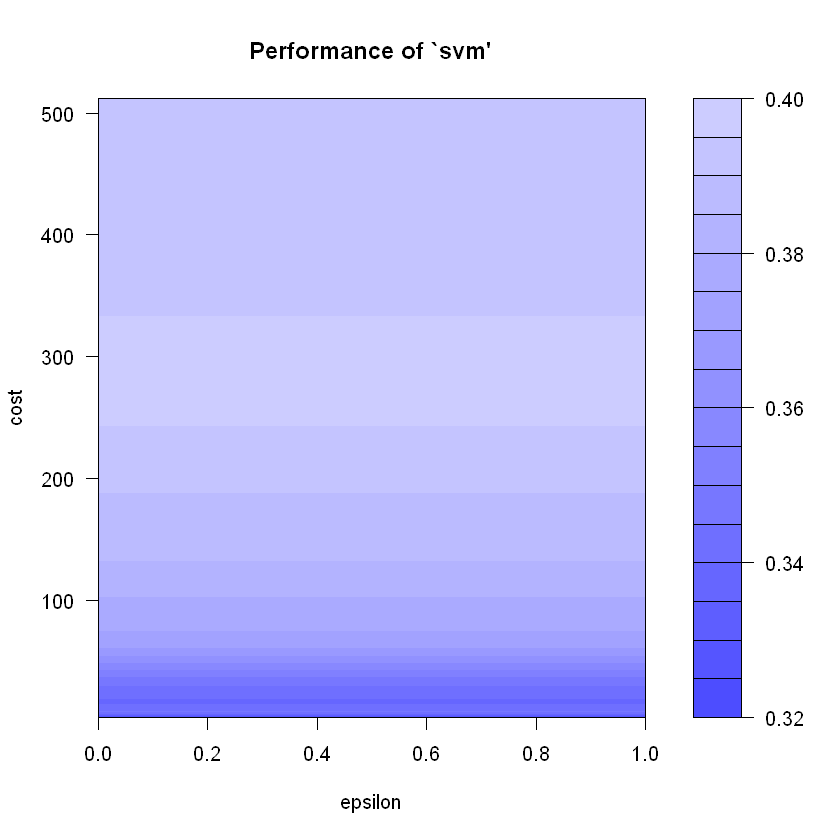

In [58]:
smv.epsilon <- tune(svm, type ~ bone_length + rotting_flesh + hair_length, data = train,
              ranges = list(epsilon = seq(0,1,0.1), cost = 2^(2:9))
)
print(smv.epsilon )

plot(smv.epsilon )

Maintenant qu'on a choisi le paramètre epsilon optimal, égal à 0, testons notre modèle sur l'échantillon de données cross_val. 

In [59]:
model.svm <- smv.epsilon$best.model
predict.svm <- predict(model.svm, cross_val)
table<-table(predict.svm, cross_val$type)
table

accuracy<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
accuracy

           
predict.svm Ghost Ghoul Goblin
     Ghost     31     2      5
     Ghoul      1    21     13
     Goblin     8     5     25

[1] 0.6936937

La précision a diminué, mais cette version du modèle aura une meilleure précision quand nous aurons à classer des données qui ne sont pas dans notre échantillon.

# Random forest

In [ ]:
set.seed(10)
library(ranger)
library(caret)
model.RF <- train(
    type ~.,
    tuneLength = 3,
    data = monstres, 
    method = "ranger", 
    
    importance = 'impurity'
)

In [ ]:
rfFit$model.RF

In [ ]:
modele_hclust<-hclust(dist(monstres))

In [ ]:
plot(modele_hclust)

In [ ]:
clusterCut <- cutree(modele_hclust, 3)

In [ ]:
table<-table(clusterCut, monstres$type)
table

accuracy<-(table[1,1]+table[2,2]+table[3,3])/sum(table)
accuracy

In [ ]:
library(nnet)
test <- multinom(type2 ~ bone_length + rotting_flesh + hair_length+has_soul+color+bone_time_soul+
               hair_time_soul+bone_hair_soul+bone_hair_soul_square, data = monstres)

In [ ]:
summary(test)

In [ ]:
summary(test)$coefficients/summary(test)$standard.errors

In [ ]:
head(pred <- fitted(test))

In [ ]:
result<-predict(test,monstres_test,"probs")